In [2]:
from viz import db, Annotation

import json
import os

from collections import namedtuple
from itertools import groupby
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np

from conllu.parser import parse as conllu_parse
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline

In [10]:
DATA_ROOT = 'static/datasubset/'

def create_data(filename):
    with open(os.path.join(DATA_ROOT, 'english_parsed', filename), encoding='utf-8') as f:
        english = conllu_parse(f.read())
    with open(os.path.join(DATA_ROOT, 'hebrew_parsed', filename), encoding='utf-8') as f:
        hebrew = conllu_parse(f.read())
    with open(os.path.join(DATA_ROOT, 'english_srl', filename), encoding='utf-8') as f:
        english_srl = [json.loads(line.strip()) for line in f]
    with open(os.path.join(DATA_ROOT, 'fastalign_outputs', filename + '.forward'), encoding='utf-8') as f:
        alignment = []
        for line in f:
            dashed_pairs = line.strip().split(' ')
            pairs = [(int(i), int(j)) for i, j in [p.split('-') for p in dashed_pairs]]
            alignment.append(pairs)
    sents = []
    for en, he, srl, alignment_ in zip(english, hebrew, english_srl, alignment):
        obj = {
            'imdbid': filename.split('_')[2],
            'english': {
                'frames': srl['frames'],
                'words': en
            },
            'hebrew': {
                'words': he
            },
            'alignment': alignment_,
        }
        sents.append(obj)
    return sents

Node = namedtuple('Node', 'token distance')

def parse_tree_depth(sentence, root):
    visited, stack = [], [root]
    while stack:
        node = stack.pop()
        if node not in visited:
            visited.append(node)
            stack.extend([Node(t, node.distance + 1) for t in sentence if t['head'] == node.token['id']])
    return max(visited, key=itemgetter(1)).distance


def features(sentence):
    # rating = ia.get_movie(sentence['imdbid']).get('rating', 0.0)
    en_sent_length = len(sentence['english']['words'])
    he_sent_length = len(sentence['hebrew']['words'])
    nframes = len(sentence['english']['frames'])
    alignment = sorted(sentence['alignment'])
    alignment_groups = []
    for _, g in groupby(alignment, key=itemgetter(0)):
        alignment_groups.append(list(g))
    one_to_ones = len([g for g in alignment_groups if len(g) == 1])
    one_to_manys = len(alignment_groups) - one_to_ones

    en_head, = [x for x in sentence['english']['words'] if x['head'] == 0]
    he_head, = [x for x in sentence['hebrew']['words'] if x['head'] == 0]
    en_parse_tree_depth = parse_tree_depth(sentence['english']['words'], Node(en_head, 0))
    he_parse_tree_depth = parse_tree_depth(sentence['hebrew']['words'], Node(he_head, 0))

    return {
        'en-sent-length': en_sent_length,
        'he-sent-length': he_sent_length,
        'en-he-ratio': en_sent_length / he_sent_length,
        'number-of-frames': nframes,
        '1-1s': one_to_ones,
        '1-ns': one_to_manys,
        'en-parse-tree-depth': en_parse_tree_depth,
        'he-parse-tree-depth': he_parse_tree_depth
    }

In [11]:
files = os.listdir('static/datasubset/english_parsed/')
d = create_data(files[0])[0]

In [49]:
from itertools import groupby
from operator import itemgetter

def project_srl(english_srl, alignment):
    he2en_alignment = {}
    for key, group in groupby(sorted(alignment, key=itemgetter(1)), key=itemgetter(1)):
        he2en_alignment[key], = list(map(itemgetter(0), group))
    hebrew_srl = english_srl
    for obj in hebrew_srl:
        obj['target']['spans'][0]['start'] = he2en_alignment[obj['target']['spans'][0]['start']]
        obj['target']['spans'][0]['end'] = he2en_alignment[obj['target']['spans'][0]['end']]
        for fe in obj['annotationSets'][0]['frameElements']:
            fe['spans'][0]['start'] = he2en_alignment[fe['spans'][0]['start']]
            fe['spans'][0]['end'] = he2en_alignment[fe['spans'][0]['end']]
    return hebrew_srl

project_srl(d['english']['frames'], d['alignment'])

[{'annotationSets': [{'frameElements': [{'name': 'Message',
      'spans': [{'end': 14,
        'start': 3,
        'text': 'When you make a friend , you take on a responsibility'}]},
     {'name': 'Speaker',
      'spans': [{'end': 0, 'start': 0, 'text': 'Amanonce'}]}],
    'rank': 0,
    'score': 125.06292807463431}],
  'target': {'name': 'Statement',
   'spans': [{'end': 3, 'start': 0, 'text': 'said'}]}},
 {'annotationSets': [{'frameElements': [],
    'rank': 0,
    'score': 24.19445037584726}],
  'target': {'name': 'Temporal_collocation',
   'spans': [{'end': 3, 'start': 3, 'text': 'When'}]}},
 {'annotationSets': [{'frameElements': [{'name': 'Cause',
      'spans': [{'end': 4, 'start': 6, 'text': 'you'}]},
     {'name': 'Effect',
      'spans': [{'end': 8, 'start': 5, 'text': 'a friend'}]}],
    'rank': 0,
    'score': 64.00957827767974}],
  'target': {'name': 'Causation',
   'spans': [{'end': 3, 'start': 3, 'text': 'make'}]}},
 {'annotationSets': [{'frameElements': [],
    'rank':

In [29]:
def transform_to_dataset(annotations):
    X, y = [], []
    for a in annotations:
        filename = a.file
        sent_idx = a.sentence
        label = a.message == 'ok'
        X.append(features(create_data(filename)[sent_idx]))
        y.append(label)
    return X, y

In [30]:
X_train, X_test, y_train, y_test = train_test_split(*transform_to_dataset(Annotation.query.all()), random_state=0)

In [41]:
vectorizer = DictVectorizer()
multinomial_nb = MultinomialNB()

clf = Pipeline([
        ('vectorizer', vectorizer),
        ('over-sampler', RandomOverSampler(random_state=0)),
        ('classifier', multinomial_nb)
    ])

clf.fit(X_train, y_train)

print('Training Completed')

Training Completed


In [43]:
for coef, fn in sorted(zip(multinomial_nb.coef_.tolist()[0], vectorizer.get_feature_names())):
    print('%.4f' % (coef,), fn, sep='\t')

-3.8465	en-he-ratio
-3.1323	1-ns
-2.6080	en-parse-tree-depth
-2.4838	number-of-frames
-2.3554	he-parse-tree-depth
-1.8269	1-1s
-1.3585	en-sent-length
-1.3277	he-sent-length


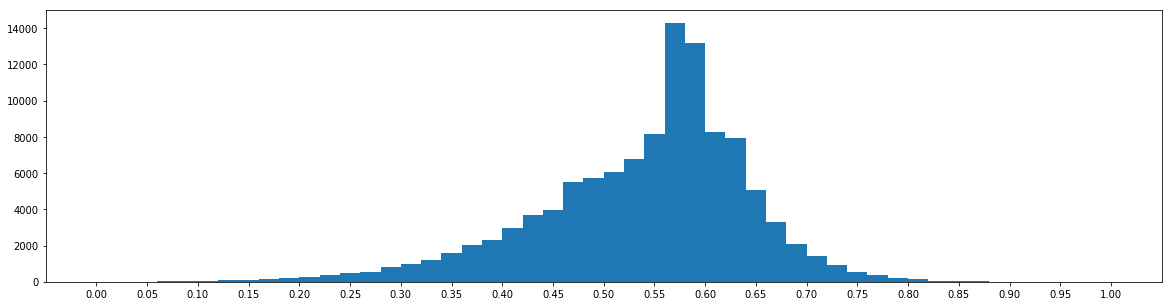

In [44]:
DATA_ROOT = 'static/dataset/'

X = []
sents = []
files = os.listdir('static/dataset/english_parsed/')
for file in files:
    try:
        data = create_data(file)
        for idx, sent in enumerate(data):
            try:
                features_ = features(sent)
                X.append(features_)
                sents.append((file, idx))
            except ValueError:
                pass
    except ValueError:
        continue

plt.figure(figsize=(20, 5))
plt.hist(clf.predict_proba(X)[:,1], bins=50, range=(0, 1))
plt.xticks(np.linspace(0, 1, 21))
plt.savefig('proba.png')

In [13]:
len(sents)

112004

In [46]:
predicted_proba = clf.predict_proba(X)[:, 1]

for (file, idx), y_prob in zip(sents, predicted_proba):
    if y_prob >= 0.80:
        db.session.add(Annotation(file=file, sentence=idx, message='ok'))
db.session.commit()

In [45]:
true_proba = clf.predict_proba(X)[:, 1]
true_proba[true_proba >= 0.80].size

274